In [1]:
import random
import numpy as np
import mmcv
from tools_custom.dataset import *
from pathlib import Path
import pprint
from PIL import Image
from collections import defaultdict
from tools_custom.config import cfg
from mmdet.datasets import get_dataset
from PIL import Image
import cv2
import numpy as np


image_prefix = 'data/dataset/images'

In [2]:
ds = get_dataset(cfg.data.train)
coco = ds.coco

In [7]:
def get_normal_imgs(coco):
    img_ids = coco.getImgIds()
    ann_ids = coco.getAnnIds()
    anns = coco.loadAnns(ids=ann_ids)
    det_img_ids = [ann['image_id'] for ann in anns]
    normal_img_ids = list(set(img_ids) - set(det_img_ids))
    return coco.loadImgs(ids=normal_img_ids)

    

normal_imgs = get_normal_imgs(coco)
normal_imgs[0]

{'coco_url': '',
 'data_captured': '',
 'file_name': '190103_151312_00149749.jpg',
 'id': 981,
 'flickr_url': '',
 'license': 1,
 'height': 682,
 'width': 1151,
 'filename': '190103_151312_00149749.jpg'}

In [4]:
def get_det_imgs(coco):
    ann_ids = coco.getAnnIds()
    anns = coco.loadAnns(ids=ann_ids)
    det_img_ids = set([ann['image_id'] for ann in anns])
    return coco.loadImgs(ids=det_img_ids)

    

det_imgs = get_det_imgs(coco)
det_imgs[0]

{'coco_url': '',
 'data_captured': '',
 'file_name': '190119_184244_00166940.jpg',
 'flickr_url': '',
 'id': 0,
 'height': 391,
 'width': 680,
 'license': 1,
 'filename': '190119_184244_00166940.jpg'}

In [5]:
def get_det_category_imgs(coco, return_ids=False):
    img_ids = coco.getImgIds()
    ann_ids = coco.getAnnIds()
    anns = coco.loadAnns(ids=ann_ids)
    det_img_ids = [ann['image_id'] for ann in anns]
    normal_img_ids = list(set(img_ids) - set(det_img_ids))
    if return_ids:
        return coco.loadImgs(ids=normal_img_ids), normal_img_ids
    else:
        return coco.loadImgs(ids=normal_img_ids)


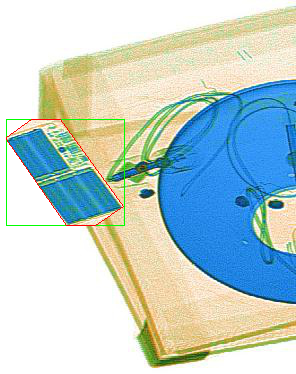

In [35]:
def convert_flat_to_pair_polygon(polygon):
    # polygon: [x1, y1, x2, y2, ...]
    # return [(x1, y1), (x2, y2), ...]
    x_list = [polygon[i] for i in range(len(polygon)) if i%2==0]
    y_list = [polygon[i] for i in range(len(polygon)) if i%2!=0]
    points = [(_x, _y) for _x, _y in zip(x_list, y_list)]
    return points


def convert_pair_to_flat_polygon(polygon):
    # polygon: [(x1, y1), (x2, y2), ...]
    # return: [(x1, y1, x2, y2, ...)]
    converted = []
    for x, y in polygon:
        converted += [x, y]
    return [tuple(converted)]


def choice_random_position(bbox, img_size):
    # bbox: [x, y, w, h]
    # img_size: [h, w, (c)]
    # return: left top (x, y)
    x, y, w, h = bbox
    height, width = img_size[:2]
    max_valid_x = width - w - 1
    max_valid_y = height - h - 1
    position_x = random.randint(0, max_valid_x)
    position_y = random.randint(0, max_valid_y)
    return (position_x, position_y)


def adjust_det_polygon(polygon, bbox_x, bbox_y):
    # polygon: [x1, y1, x2, y2, ...]
    # bbox_x, bbox_y: det image's bbox x, y
    # return: [(x1, y1), (x2, y2), ...] adjusted flat polygon
    pair_polygon = convert_flat_to_pair_polygon(polygon)
    adjusted_pair_polygon = []
    for x, y in pair_polygon:
        adjusted_x = x - bbox_x
        adjusted_y = y - bbox_y
        adjusted_pair_polygon.append((adjusted_x, adjusted_y))
    return adjusted_pair_polygon


def adjust_patch_polygon(polygon, bbox_x, bbox_y, patch_x, patch_y):
    # polygon: [x1, y1, x2, y2, ...]
    # bbox_x, bbox_y: det image's bbox x, y
    # patch_x, patch_y: a random choosen pair of (x, y) to place patch block
    # return: [(x1, y1), (x2, y2), ...] adjusted flat polygon
    pair_polygon = convert_flat_to_pair_polygon(polygon)
    adjusted_pair_polygon = []
    for x, y in pair_polygon:
        adjusted_x = x + patch_x - bbox_x
        adjusted_y = y + patch_y - bbox_y
        adjusted_pair_polygon.append((adjusted_x, adjusted_y))
    return adjusted_pair_polygon


def adjust_patch_bbox(bbox, patch_x, patch_y):
    # bbox: [x, y, w, h] det bbox
    # patch_x, patch_y: patched bbox position
    # return patch_bbox: [x, y, w, h] patch bbox
    x, y, w, h = bbox
    return (patch_x, patch_y, w, h)


def do_patch_polygon(det_rect, det_polygon, patch_rect):
    mask = np.zeros(shape=det_rect.shape[:2], dtype=np.uint8)
    mask = cv2.fillConvexPoly(mask, np.array([det_polygon]), 255)
    mask_inv = cv2.bitwise_not(mask)
    det_fg = cv2.bitwise_and(det_rect, det_rect, mask=mask)
    patch_bg = cv2.bitwise_and(patch_rect, patch_rect, mask=mask_inv)
    patched_rect = cv2.add(det_fg, patch_bg)
    return patched_rect
    

def do_patch(det_img, bbox, polygon, normal_img):
    # det_img: (h, w, c) det cv2 image
    # bbox: [x, y, w, h] det bbox
    # polygon: [x1, y1, x2, y2, ...] det polygon
    # normal_img: (h, w, c) normal cv2 image
    x, y, w, h = bbox
    det_rect = det_img[y:y+h, x:x+w, ...].copy()
    patch_x, patch_y = choice_random_position(bbox, normal_img.shape)
    patch_rect = normal_img[patch_y:patch_y+h, patch_x:patch_x+w, ...]
    
    det_polygon = adjust_det_polygon(polygon, x, y)
    patch_polygon = adjust_patch_polygon(polygon, x, y, patch_x, patch_y)
    patch_bbox = adjust_patch_bbox(bbox, patch_x, patch_y)
    
    patched_rect = do_patch_polygon(det_rect, det_polygon, patch_rect)
    normal_img[patch_y:patch_y+h, patch_x:patch_x+w, ...] = patched_rect
    return normal_img, patch_bbox, convert_pair_to_flat_polygon(patch_polygon)


def get_pair():
    det_id = random.randint(0, len(det_imgs))
    normal_id = random.randint(0, len(normal_imgs))
    return det_imgs[det_id], normal_imgs[normal_id]

det_img, normal_img = get_pair()
det_ann_ids = coco.getAnnIds(imgIds=det_img['id'])
det_anns = coco.loadAnns(ids=det_ann_ids)
det_bboxes = [ann['bbox'] for ann in det_anns] # [[x, y, w, h], ...]
det_segs = [ann['segmentation'][0] for ann in det_anns] # [[x1, y1, x2, y2, ...], ...]

det_filename = det_img['file_name']
normal_filename = normal_img['file_name']

det_pil_img = Image.open('data/dataset/images/' + det_filename)
det_cv2_img = np.array(det_pil_img)

normal_pil_img = Image.open('data/dataset/images/' + normal_filename)
normal_cv2_img = np.array(normal_pil_img)

bboxes = []
polygons = []
patched_normal_cv2_img = normal_cv2_img.copy()
for bbox, polygon in zip(det_bboxes, det_segs):
    _, bbox, polygon = do_patch(det_cv2_img, bbox, polygon, patched_normal_cv2_img)
    bboxes.append(bbox)
    polygons.append(polygon)
    

bboxes = np.array(bboxes)
bboxes[:, 2] += bboxes[:, 0]
bboxes[:, 3] += bboxes[:, 1]
labels = np.zeros(bboxes.shape[0])

patched_normal_pil_img = Image.fromarray(patched_normal_cv2_img)
mmcv.imshow_polygon_bboxes(patched_normal_pil_img, bboxes=bboxes, polygons=polygons, polygon_color='red', thickness=1, text_color='green')

In [18]:
def show_cv2_img(cv2_img):
    print(cv2_img.shape)
    pil_img = Image.fromarray(cv2_img.astype('uint8'))
    return pil_img

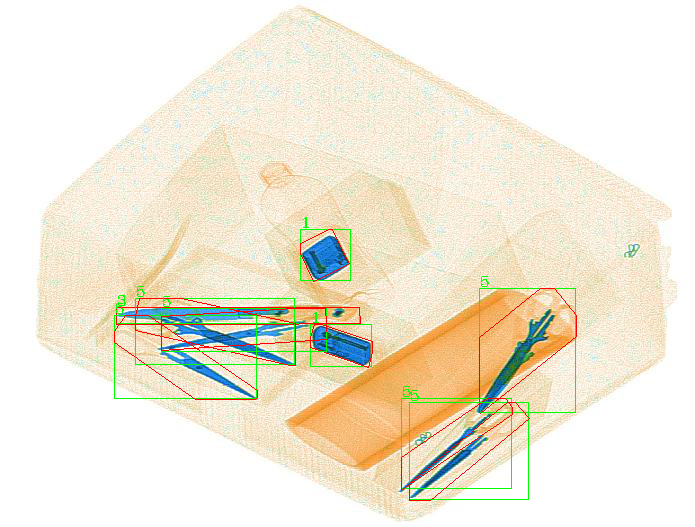

In [71]:
def get_sample(filename):
    img_info = [img_info for img_info in ds.img_infos if img_info['file_name']==filename][0].copy()
    img_info['ann'] = ds.get_ann_info(img_info['id'])
    return img_info

def get_random_sampe():
    idx = random.randint(0, len(ds))
    img_info = ds.img_infos[idx]
    img_info['ann'] = ds.get_ann_info(idx)
    return img_info

sample = get_sample(det_filename)
sample = get_random_sampe()
img = Image.open(str(Path(ds.img_prefix, sample['filename'])))
bboxes = sample['ann']['bboxes']
labels = sample['ann']['labels']
polygons = sample['ann']['mask_polys']


mmcv.imshow_polygon_bboxes(img, bboxes=bboxes, polygons=polygons, polygon_color='red', labels=labels, thickness=1, text_color='green')